# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy.linalg
import pickle as pkl
import pandas as pd
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
PATH_TO_DATA = "/Users/bfiliot/MVA/DL/TP2/data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.nmax = nmax
        self.load_wordvec(fname, nmax)
        self.word2id = {k:i for k,i in zip(self.word2vec.keys(), range(nmax))}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in tqdm(enumerate(f), total=nmax):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        print("\nNearest neighbors of \"%s\":" % w)
        # handle cases where w is not in the dictionary
        if self.word2vec.get(w) is None:
            print('Word [{}] cannot be found'.format(w))
        else:
            words = np.array(list(self.word2id.keys()))
            scores = [self.score(w, w2) for w2 in words]
            # select (K+1) most similar words (1rst is the word itself)
            id = np.argsort(scores)[-K-1::][-2::-1]
            for i in id:
                print('%.4f - %s' % (scores[i], words[i]))

    def score(self, w1, w2):
        emb1, emb2 = self.word2vec.get(w1), self.word2vec.get(w2)
        # handle cases where w1 or w2 is not in the dictionary
        if emb1 is None:
            print('Word [{}] cannot be found'.format(w1))
        elif emb2 is None:
            print('Word [{}] cannot be found'.format(w2))
        else:
            return np.dot(emb1, emb2) / np.linalg.norm(emb1, 2) / np.linalg.norm(emb2, 2)

In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

'''You will be evaluated on the output of the following:'''

print('\nTesting score...\n')
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'),
                  ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, ' : %.4f ' % w2v.score(w1, w2))
print('\nTesting similarity...\n')
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    w2v.most_similar(w1)

Loaded 200000 pretrained word vectors

Testing score...

cat dog  : 0.6717 
dog pet  : 0.6842 
dogs cats  : 0.7074 
paris france  : 0.7775 
germany berlin  : 0.7420 

Testing similarity...


Nearest neighbors of "cat":
0.8353 - cats
0.8034 - kitty
0.8025 - kitten
0.7681 - feline
0.7237 - kitties

Nearest neighbors of "dog":
0.8552 - dogs
0.7846 - puppy
0.7512 - Dog
0.7442 - doggie
0.7421 - canine

Nearest neighbors of "dogs":
0.8552 - dog
0.7713 - pooches
0.7704 - Dogs
0.7699 - doggies
0.7527 - canines

Nearest neighbors of "paris":
0.7775 - france
0.6845 - Paris
0.6787 - parisian
0.6729 - london
0.6424 - berlin

Nearest neighbors of "germany":
0.7688 - austria
0.7598 - europe
0.7446 - german
0.7420 - berlin
0.7237 - poland


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        '''takes a list of sentences, outputs a numpy array of sentence embeddings
        see TP1 for help'''
        sentemb = []
        for sent in sentences:
            words = [w for w in sent.split(' ') if w in w2v.word2vec.keys()]
            # control if words is empty. The latter means that none of the words
            # from the sentence can be found in the dictionary for specified nmax.
            # This sentence is not taken into account to construct the embeddings.
            if not words:
                print("None of the words in the sentence \n'"+sent+"'\ncan be found")
                continue
            if idf is False:
                emb = np.mean([w2v.word2vec.get(w) for w in words], axis=0)
            else:
                emb = np.mean([w2v.word2vec.get(w)*idf.get(w) for w in words], axis=0)
            sentemb.append(emb)
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        '''get most similar sentences and **print** them'''
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        scores = [self.score(query[0], k) for k in keys]
        # select (K+1) most similar sentences (1rst is the sentence itself)
        id = np.argsort(scores)[-K-1::][-2::-1]
        for i in id:
            print('%.4f - %s' % (scores[i], sentences[i]))

    def score(self, s1, s2, idf=False):
        '''cosine similarity: use   np.dot  and  np.linalg.norm
        score can take either raw sentences (string) or encoded ones (embeddings).
        In the first case s1/s2 are strings and we must distinguish strings 
        from other formats using isinstance.'''
        emb1 = self.encode([s1], idf)[0] if isinstance(s1, str) else s1
        emb2 = self.encode([s2], idf)[0] if isinstance(s2, str) else s2
        score = np.dot(emb1, emb2) / np.linalg.norm(emb1) / np.linalg.norm(emb2)
        return score
    
    def build_idf(self, sentences):
        '''build the idf dictionary: associate each word to its idf value'''
        idf = {}
        for sent in sentences:
            for w in sent.split(' '):
                idf[w] = idf.get(w, 0) + 1
        idf = {w: max(1, np.log10(len(sentences) / (idf[w]))) for w in idf.keys()}
        return idf

In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

'''Load sentences in "PATH_TO_DATA/sentences.txt"'''
def load_sentences(fname):
    sentences = []
    with io.open(fname, encoding='utf-8') as f:
        for _, line in enumerate(f):
            sentences.append(line.rstrip())
    return sentences
sentences = load_sentences(os.path.join(PATH_TO_DATA, 'sentences.txt'))

'''Build idf scores for each word'''
idf = s2v.build_idf(sentences)

'''You will be evaluated on the output of the following:'''

# BoV-MEAN
sent = sentences[10] 
print("Nearest neighbors (Bov-Mean) of \"%s\":" % sent)
s2v.most_similar('' if not sentences else sent, sentences)  # BoV-mean
sent1, sent2 = sentences[7], sentences[13] 
print("\nTesting score (BoV-mean) with sentences...\n\"%s\"\nand\n\"%s\"" % (sent1, sent2))
print('➜ Score : %.4f' % (s2v.score('' if not sentences else sent1, '' if not sentences else sent2)))

# BoV-Idf-mean
sent = sentences[10] 
print("\nNearest neighbors (BoV-Idf-Mean) of \"%s\":" % sent)
s2v.most_similar('' if not sentences else sent, sentences, idf)  # Bov-Idf-mean
sent1, sent2 = sentences[7], sentences[13] 
print("\nTesting score (BoV-Idf-Mean) with sentences...\n\"%s\"\nand\n\"%s\"" % (sent1, sent2))
print('➜ Score : %.4f' % (s2v.score('' if not sentences else sent1, '' if not sentences else sent2, idf)))

Loaded 200000 pretrained word vectors
Nearest neighbors (Bov-Mean) of "1 smiling african american boy .":
0.9170 - an african american man smiling .
0.8499 - a little african american boy and girl looking up .
0.8217 - an afican american woman standing behind two small african american children .
0.8207 - an african american man is sitting .
0.8191 - a girl in black hat holding an african american baby .

Testing score (BoV-mean) with sentences...
"1 man singing and 1 man playing a saxophone in a concert ."
and
"10 people venture out to go crosscountry skiing ."
➜ Score : 0.5726

Nearest neighbors (BoV-Idf-Mean) of "1 smiling african american boy .":
0.9222 - an african american man smiling .
0.8718 - an african american man is sitting .
0.8654 - a little african american boy and girl looking up .
0.8552 - an afican american woman standing behind two small african american children .
0.8467 - a girl in black hat holding an african american baby .

Testing score (BoV-Idf-Mean) with sent

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [8]:
'''1 - Download and load 50k first vectors of
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec'''

w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000).word2vec
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000).word2vec

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [9]:
'''2 - Get words that appear in both vocabs (= identical character strings)
Use it to create the matrix X and Y (of aligned embeddings for these words)'''

words_fr, words_en = set(w2v_fr), set(w2v_en)
words_both = list(words_fr & words_en)
X, Y = [], []
for w in words_both:
    X.append(w2v_fr.get(w))
    Y.append(w2v_en.get(w))
X, Y = np.stack(X).T, np.stack(Y).T

In [10]:
'''3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
Now W*French_vector is in the same space as English_vector'''

U, S, Vt = scipy.linalg.svd(np.dot(Y, X.T))
W = np.dot(U, Vt)
WX = np.dot(W, X).T
WtY = np.dot(W.T, Y).T

In [11]:
'''4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
You will be evaluated on that part and the code above'''

w2v_fr2, w2v_en2 = {}, {}
for i, w in enumerate(words_both) :
    w2v_fr2[w] = WX[i]
    w2v_en2[w] = WtY[i]
    
def most_similar(word, w2v_sr, w2v_tg, K=5):
    emb = w2v_sr.get(word)
    scores = [np.dot(emb, w2v_tg.get(w2)) / np.linalg.norm(emb, 2) / 
                     np.linalg.norm(w2v_tg.get(w2), 2) for w2 in words_both]
    id = np.argsort(scores)[-K::][::-1]
    for i in id:
        print('%.4f - %s' % (scores[i], words_both[i]))

'''You will be evaluated on the output of the following:'''

for w1 in ['réserviste', 'maintenir', 'télésiège', 'exclut', 'copropriété']:
    print("\nEnglish nearest neighbors of \"%s\":" % w1)
    most_similar(w1, w2v_fr, w2v_en2)
print('_____________________________________________________________')
for w1 in ['workforce', 'subscriber', 'scorn', 'uncontrollable', 'friendships']:
    print("\nFrench nearest neighbors of \"%s\":" % w1)
    most_similar(w1, w2v_en, w2v_fr2)


English nearest neighbors of "réserviste":
0.4872 - sergeant
0.4562 - colonel
0.4466 - commandos
0.4407 - captain
0.4393 - officer

English nearest neighbors of "maintenir":
0.4544 - conserve
0.4288 - secure
0.4151 - impose
0.3924 - compromise
0.3842 - assure

English nearest neighbors of "télésiège":
0.5486 - ski
0.5202 - chalet
0.4554 - skis
0.4335 - snowboard
0.4176 - alpine

English nearest neighbors of "exclut":
0.5171 - exclusion
0.4848 - regard
0.4358 - exceptions
0.4355 - indirect
0.4326 - justifications

English nearest neighbors of "copropriété":
0.4997 - property
0.4662 - tenant
0.4416 - estate
0.4401 - tenants
0.4226 - acquisition
_____________________________________________________________

French nearest neighbors of "workforce":
0.5015 - entrepreneurs
0.4942 - industrialisation
0.4704 - industries
0.4615 - professions
0.4538 - management

French nearest neighbors of "subscriber":
0.6056 - adsl
0.5793 - ethernet
0.5617 - gsm
0.5456 - wifi
0.5194 - bluetooth

French near

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [27]:
'''1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
(https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)'''

def load_SST_sentences(fname):
    Y, sentences = [], []
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            y, s = line.split(' ', 1)
            Y.append(y)
            sentences.append(s.strip())
    return pd.DataFrame({'X':sentences, 'Y':Y})
          
train = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

In [28]:
'''2 - Encode sentences with the BoV model above'''

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

def add_embeddings(df, idf):
    X = df['X']
    emb = pd.DataFrame(s2v.encode(X, idf), columns=['e'+str(i) for i in range(1, 301)])
    df_ = pd.concat((df, emb), axis=1)
    return df_, df_['Y'], df_.iloc[:,2:]

# Weighted average with idf
train_idf, y_train_idf, X_train_idf = add_embeddings(train, s2v.build_idf(train['X']))
dev_idf, y_dev_idf, X_dev_idf = add_embeddings(dev, s2v.build_idf(dev['X']))
test_idf, y_test_idf, X_test_idf = add_embeddings(test, s2v.build_idf(test['X']))
# No weighted average
train, y_train, X_train = add_embeddings(train, False)
dev, y_dev, X_dev = add_embeddings(dev, False)
test, y_test, X_test = add_embeddings(test, False)

In [14]:
'''3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
(consider tuning the L2 regularization on the dev set)'''

from sklearn.linear_model import LogisticRegression

#param_grid = sorted([x*y for x,y in itertools.product(range(1,10), [10**i for i in range(-2,3)])])
param_grid = np.linspace(0.045, 0.055, 11)
param_grid_idf = np.linspace(1, 3, 21)
results, results_idf = {}, {}

for c, ci in tqdm(zip(param_grid, param_grid_idf), total=11):
    continue # to remove if needed
    clf = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='ovr',
                             penalty='l2', C = c)
    clfi = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='ovr',
                             penalty='l2', C = ci)
    clf.fit(X_train, y_train)
    clfi.fit(X_train_idf, y_train_idf)
    results[c] = clf.score(X_dev, y_dev)
    results_idf[ci] = clf.score(X_dev_idf, y_dev_idf)

In [47]:
'''4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
You will be evaluated on the results of the test set.'''

# Best penalty coefficient is 2.6 (after gridsearching on dev test) with weighted average
# Best penalty coefficient is 0.05 (after gridsearching on dev test) without weighted average
clf_opt_idf = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='ovr',
                               penalty='l2', C = 2.6).fit(X_train_idf, y_train_idf)
print("Accuracy on train set (idf-w): %0.3f " % clf_opt_idf.score(X_train_idf, y_train_idf))
print("Accuracy on dev set (idf-w): %0.3f " % clf_opt_idf.score(X_dev_idf, y_dev_idf))
clf_opt = LogisticRegression(max_iter=100, solver='lbfgs', multi_class='ovr',
                               penalty='l2', C = 0.7).fit(X_train, y_train)
print("Accuracy on train set (mean): %0.3f " % clf_opt.score(X_train, y_train))
print("Accuracy on dev set (mean): %0.3f " % clf_opt.score(X_dev, y_dev))
# Save predictions with idf-weighted average
y_pred = clf_opt.predict(X_test).astype('float')
np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_bov_y_test_sst.txt'), y_pred, delimiter=',', fmt='%0.0f')

Accuracy on train set (idf-w): 0.494 
Accuracy on dev set (idf-w): 0.432 
Accuracy on train set (mean): 0.486 
Accuracy on dev set (mean): 0.443 


In [16]:
'''BONUS!
5 - Try to improve performance with another classifier
Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier
'''
from sklearn import svm
svm_idf = svm.LinearSVC(C=0.034) # optimal value 
svm_idf.fit(X_train, y_train)
print("Accuracy on train set (mean) %.3f" % svm_idf.score(X_train, y_train))
print("Accuracy on dev set (mean) %.3f" % svm_idf.score(X_dev, y_dev))
y_pred_svm = svm_idf.predict(X_test).astype('float')
np.savetxt(os.path.join(PATH_TO_DATA, 'svm_bov_y_test_sst.txt'), y_pred_svm, delimiter=',', fmt='%0.0f')

Accuracy on train set (mean) 0.474
Accuracy on dev set (mean) 0.444


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [7]:
import keras

Using TensorFlow backend.


In [5]:
'''1 - Load train/dev/test sets of SST'''

PATH_TO_DATA = "/Users/bfiliot/MVA/DL/TP2/data/"

import re 

def cleanStr(string):
    string=re.sub(r'^A-Za-z0-9(),!?\'\`',' ',string)
    string=re.sub(r'\s{2,}',' ',string)
    string=string.replace('Ã¡','á').replace('Ã©','é').replace('Ã±','ñ').replace('Â','').replace('Ã¯','ï')
    string=string.replace('Ã¼','ü').replace('Ã¢','â').replace('Ã¨','è').replace('Ã¶','ö').replace('Ã¦','æ')
    string=string.replace('Ã³','ó').replace('Ã»','û').replace('Ã´','ô').replace('Ã£','ã').replace('Ã§','ç')
    string=string.replace('Ã  ','à ').replace('Ã','í').replace('í','í')
    string=string.replace('-lrb-','(').replace('-rrb-',')').replace('\n','')
    return string

def load_SST_sentences(fname):
    Y, sentences = [], []
    with io.open(fname, encoding='utf-8') as f: 
        next(f)
        for i, line in enumerate(f):
            y, s = line.split(' ', 1)
            Y.append(y)
            s = cleanStr(s)
            sentences.append(s)
    return pd.DataFrame({'X':sentences, 'Y':Y})
          
train = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'))
dev = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'))
test = load_SST_sentences(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test.X'))

In [8]:
'''2 - Transform text to integers using keras.preprocessing.text.one_hot function
https://keras.io/preprocessing/text/'''

df = pd.concat((train['X'], dev['X'], test['X']))
vocab = set(df.apply(lambda x: keras.preprocessing.text.text_to_word_sequence(x)).sum())
vocab_size = len(vocab)
print('Vocab_size : {}'.format(vocab_size))
train['X_enc'] = train['X'].apply(lambda x: keras.preprocessing.text.one_hot(x, n=vocab_size))
dev['X_enc']   = dev['X'].apply(lambda x: keras.preprocessing.text.one_hot(x, n=vocab_size))
test['X_enc']  = test['X'].apply(lambda x: keras.preprocessing.text.one_hot(x, n=vocab_size))

Vocab_size : 17794


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
'''3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
https://keras.io/preprocessing/sequence/'''

maxlen = max(train['X_enc'].apply(len).max(),
             test['X_enc'].apply(len).max(),
             dev['X_enc'].apply(len).max())

def add_paddings(df):
    pad = pd.DataFrame(keras.preprocessing.sequence.pad_sequences(df['X_enc'],
                                                                  maxlen=maxlen),
                       columns=['v'+str(i) for i in range(1, 52)])
    df_ = pd.concat((df, pad), axis=1)
    return df_, df_['Y'], df_.iloc[:,3:]

train, y_train, X_train = add_paddings(train)
dev, y_dev, X_dev = add_paddings(dev)
test, y_test, X_test = add_paddings(test)

## 4.2 - Design and train your model

In [66]:
'''4 - Design your encoder + classifier using keras.layers
     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
     All of these components are contained in the Sequential() and are trained together.

'''

from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Reshape, Dropout, Embedding, LSTM, Bidirectional, Conv2D, MaxPooling2D

embed_dim  = maxlen  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = vocab_size  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2)) 
model.add(Dense(n_classes, activation='softmax'))

In [67]:
'''5 - Define your loss/optimizer/metrics'''

# MODIFY CODE BELOW

loss_classif     =  'sparse_categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 51)          907494    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               92160     
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 645       
Total params: 1,000,299
Trainable params: 1,000,299
Non-trainable params: 0
_________________________________________________________________
None


Train on 8543 samples, validate on 1100 samples
Epoch 1/5
8543/8543 [==============================] - 283s 33ms/step - loss: 1.5040 - acc: 0.3334 - val_loss: 1.4209 - val_acc: 0.3782

Epoch 00001: val_acc improved from -inf to 0.37818, saving model to LSTM-01-0.3782.hdf5
Epoch 2/5
8543/8543 [==============================] - 259s 30ms/step - loss: 1.2071 - acc: 0.4857 - val_loss: 1.4134 - val_acc: 0.3900

Epoch 00002: val_acc improved from 0.37818 to 0.39000, saving model to LSTM-02-0.3900.hdf5
Epoch 3/5
8543/8543 [==============================] - 271s 32ms/step - loss: 0.8869 - acc: 0.6502 - val_loss: 1.6099 - val_acc: 0.3555

Epoch 00003: val_acc did not improve from 0.39000
Epoch 4/5
8543/8543 [==============================] - 264s 31ms/step - loss: 0.6208 - acc: 0.7686 - val_loss: 1.9792 - val_acc: 0.3564

Epoch 00004: val_acc did not improve from 0.39000
Epoch 5/5
8543/8543 [==============================] - 259s 30ms/step - loss: 0.4491 - acc: 0.8314 - val_loss: 2.2118 - val_a

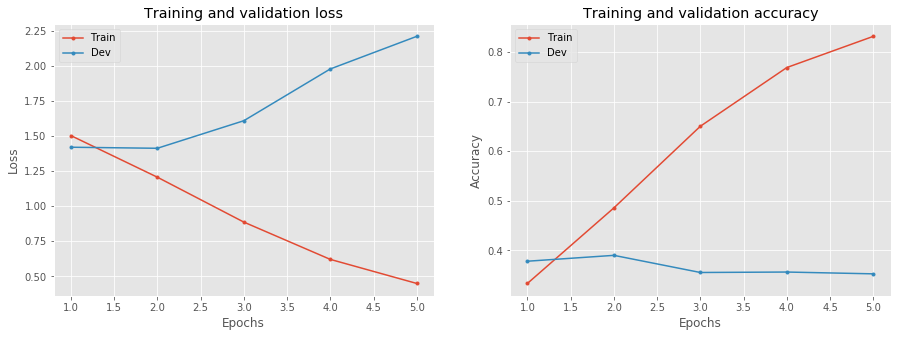

In [68]:
'''6 - Train your model and find the best hyperparameters for your dev set
you will be evaluated on the quality of your predictions on the test set'''

# ADAPT CODE BELOW
bs = 8
n_epochs = 5
filepath="LSTM-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs,
                    validation_data=(X_dev, y_dev), callbacks=callbacks_list)

def plot_loss(h):
    epoches = np.array(h.epoch)+1
    plt.figure(figsize=(15,5)); plt.subplot(121);
    plt.plot(epoches, h.history['loss'], marker='.', label='Train')
    plt.plot(epoches, h.history['val_loss'], marker='.', label='Dev')
    plt.title('Training and validation loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(122)
    plt.plot(epoches, h.history['acc'], marker='.', label='Train')
    plt.plot(epoches, h.history['val_acc'], marker='.', label='Dev')
    plt.title('Training and validation accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.legend(); plt.show()
    
plot_loss(history)

In [70]:
'''7 - Generate your predictions on the test set using model.predict(x_test)
    https://keras.io/models/model/
    Log your predictions in a file (one line = one integer: 0,1,2,3,4)
    Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.'''

model = keras.models.load_model('LSTM-02-0.3900.hdf5')
mt = model.evaluate(X_train, y_train, batch_size=bs, verbose=0)
md = model.evaluate(X_dev, y_dev, batch_size=bs, verbose=0)
print("Accuracy on train set %.3f" % mt[1])
print("Loss on train set %.3f" % mt[0])
print("Accuracy on dev set %.3f" % md[1])
print("Loss on dev set %.3f" % md[0])
y_pred_lstm = model.predict(X_test).astype('float')
np.savetxt(os.path.join(PATH_TO_DATA, 'logreg_lstm_y_test_sst.txt'), np.argmax(y_pred_lstm, axis=1), delimiter=',', fmt='%0.0f')

Accuracy on train set 0.683
Loss on train set 0.889
Accuracy on dev set 0.390
Loss on dev set 1.413


## 4.3 -- innovate !

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 51)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 51, 300)           5338200   
_________________________________________________________________
lstm_18 (LSTM)               (None, 51, 64)            93440     
_________________________________________________________________
reshape_16 (Reshape)         (None, 51, 64, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 49, 62, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 31, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 31, 32)        0         
__________

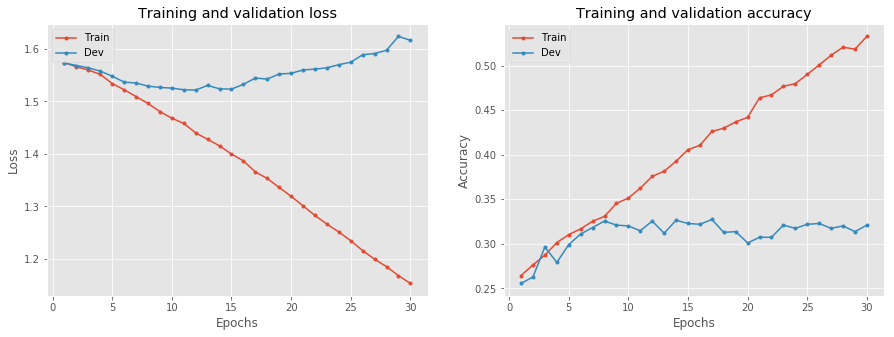

In [40]:
'''8 - Open question: find a model that is better on your dev set
    (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
    you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
    Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.'''
from keras.callbacks import ModelCheckpoint
from keras.models import Model

#Set parameters
embed_dim        = maxlen  
nhid             = 64
conv_filters     = 32
n_classes        = 5
bs               = 32
n_epochs         = 30
loss_classif     = 'sparse_categorical_crossentropy'
optimizer        = keras.optimizers.Adam(lr=10e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
metrics_classif  = ['accuracy']


# Load 2 million words from fastText or 400k words from glove
def choose_word2vec(t):
    if t=="fasttext":
        w = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=2000000).word2vec
    elif t=="glove":
        w = {}
        with io.open(os.path.join(PATH_TO_DATA, 'glove.6B.300d.txt'), encoding='utf-8') as f:
            next(f)
            for i, line in tqdm(enumerate(f), total=400000):
                word, vec = line.split(' ', 1)
                w[word] = np.fromstring(vec, sep=' ')
    return w

# create a weight matrix for words in training sentences
glove = choose_word2vec('glove')
embedding_matrix = np.random.uniform(-0.1, 0.1, size=(vocab_size, 300))
for i, word in enumerate(vocab):
    embedding_vector = glove.get(word)#w2v_en.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# put trainable=True in embedding layer to get better results
# or False in order to save computational time. I chose False
embedding_layer = Embedding(vocab_size, 300, input_length=embed_dim,
                            weights=[embedding_matrix],
                            trainable=False)
sequence_input = Input(shape=(embed_dim,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# implementation of BLSTM2DCNN : Peng et al. (2016),
# "Text Classification Improved by Integrating Bidirectional LSTM 
# with Two-dimensional Max Pooling"
x = Bidirectional(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedded_sequences)
x = Reshape((2*embed_dim, nhid, 1))(x)
x = Conv2D(conv_filters, (3, 3))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
preds = Dense(n_classes, activation='softmax')(x)
model = Model(sequence_input, preds)
model.compile(loss=loss_classif, optimizer=optimizer, metrics=metrics_classif)
filepath="BLSTM2DCNN-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False)
callbacks_list = [checkpoint]
print(model.summary())
history = model.fit(X_train, y_train, batch_size=bs, epochs=n_epochs, callbacks=callbacks_list, validation_data=(X_dev, y_dev))

#Plot loss w.r.t to the number of epochs
plot_loss(history)

# Save predictions
model = keras.models.load_model('BLSTM2DCNN-17-0.33.hdf5')
mt = model.evaluate(X_train, y_train, batch_size=bs, verbose=0)
md = model.evaluate(X_dev, y_dev, batch_size=bs, verbose=0)
y_pred_blstm = model.predict(X_test).astype('float')
np.savetxt(os.path.join(PATH_TO_DATA, 'blstm2dcnn_y_test_sst.txt'), np.argmax(y_pred_blstm, axis=1), delimiter=',', fmt='%0.0f')